In [1]:
# =============================
# 1. Load dữ liệu từ file nén
# =============================
import numpy as np

data = np.load('../input/dataset-compressed/dataset_compressed.npz')
X = data['X']
y_age = data['y_age']
y_gender = data['y_gender']

print(f"[INFO] Dữ liệu X: {X.shape}")
print(f"[INFO] Nhãn tuổi: {y_age.shape} | Nhãn giới tính: {y_gender.shape}")

# =====================================
# 2. Chia dữ liệu thành 2 phần 
# =====================================
# Chia theo tỷ lệ 2/3 và 1/3
total_samples = X.shape[0]
split_index = int(total_samples * 5 / 6)

# Dữ liệu 2/3 đầu
X1 = X[:split_index]
y_age1 = y_age[:split_index]
y_gender1 = y_gender[:split_index]

# Dữ liệu 1/3 sau
X2 = X[split_index:]
y_age2 = y_age[split_index:]
y_gender2 = y_gender[split_index:]

print(f"[INFO] X1: {X1.shape} | y_age1: {y_age1.shape} | y_gender1: {y_gender1.shape}")
print(f"[INFO] X2: {X2.shape} | y_age2: {y_age2.shape} | y_gender2: {y_gender2.shape}")

[INFO] Dữ liệu X: (14111, 227, 227, 3)
[INFO] Nhãn tuổi: (14111, 8) | Nhãn giới tính: (14111, 2)
[INFO] X1: (11759, 227, 227, 3) | y_age1: (11759, 8) | y_gender1: (11759, 2)
[INFO] X2: (2352, 227, 227, 3) | y_age2: (2352, 8) | y_gender2: (2352, 2)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model # type: ignore

def build_model(input_shape=(227, 227, 3)):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Conv1
    x = layers.Conv2D(96, (7, 7), strides=2, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = layers.BatchNormalization() (x)  

    # Conv2
    x = layers.Conv2D(256, (5, 5), strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Conv3
    x = layers.Conv2D(384, (3, 3), strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    # Flatten & Shared FC layers
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512)(x)
    x = layers.Activation('relu')(x)
    shared_features = layers.Dropout(0.5)(x)

    # Gender prediction branch (2 classes: male/female)
    gender_branch = layers.Dense(256, activation='relu')(shared_features)
    gender_branch = layers.Dropout(0.3)(gender_branch)
    gender_output = layers.Dense(2, activation='softmax', name='gender_output')(gender_branch)

    # Age prediction branch (8 classes: age groups)
    age_branch = layers.Dense(512, activation='relu')(shared_features)
    age_branch = layers.Dropout(0.3)(age_branch)
    age_branch = layers.Dense(256, activation='relu')(age_branch)
    age_branch = layers.Dropout(0.3)(age_branch)
    age_output = layers.Dense(8, activation='softmax', name='age_output')(age_branch)

    # Create model with multiple outputs
    model = Model(inputs=inputs, outputs=[gender_output, age_output])

    return model

def compile_model(model, learning_rate=0.001):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
        loss={
            'gender_output': 'categorical_crossentropy',
            'age_output': 'categorical_crossentropy'
        },
        loss_weights={
            'gender_output': 1.0,
            'age_output': 1.0
        },
        metrics={
            'gender_output': ['accuracy'],
            'age_output': ['accuracy']
        }
    )
    return model

2025-05-31 17:43:58.209271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748713438.375831      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748713438.427326      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
model = build_model(input_shape=(227, 227, 3))
model = compile_model(model, learning_rate=0.001)

I0000 00:00:1748713483.350170      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748713483.350883      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
import numpy as np
import time

def train_model(
    model=None,
    X=None,
    y_age=None,
    y_gender=None,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    model_save_path='outputs/trained_model.h5',
):
    """
    Huấn luyện mô hình sử dụng dữ liệu đã load sẵn vào RAM: X, y_age, y_gender.
    """

    # Kiểm tra đầu vào
    total_samples = X.shape[0]
    assert y_age.shape[0] == total_samples and y_gender.shape[0] == total_samples, "Kích thước không khớp!"

    # Tạo chỉ số train/val
    indices = np.arange(total_samples)
    np.random.seed(42)
    np.random.shuffle(indices)

    val_samples = int(total_samples * validation_split)
    val_indices = indices[:val_samples]
    train_indices = indices[val_samples:]

    print(f"[INFO] Tổng mẫu: {total_samples}")
    print(f"[INFO] Mẫu train: {len(train_indices)}, Mẫu val: {len(val_indices)}")

    # Tách dữ liệu theo chỉ số
    X_train, y_age_train, y_gender_train = X[train_indices], y_age[train_indices], y_gender[train_indices]
    X_val, y_age_val, y_gender_val = X[val_indices], y_age[val_indices], y_gender[val_indices]

    y_train = {
        'age_output': y_age_train,
        'gender_output': y_gender_train
    }
    y_val = {
        'age_output': y_age_val,
        'gender_output': y_gender_val
    }

    print("[INFO] Bắt đầu huấn luyện...")
    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
    )

    duration = time.time() - start_time
    print(f"[INFO] Huấn luyện hoàn tất sau {duration / 60:.2f} phút.")

    print(f"[INFO] Lưu mô hình vào {model_save_path}...")
    model.save(model_save_path)

    return history, model

In [5]:
# =============================
# 4. Train mô hình
# =============================
history, trained_model = train_model(
    model=model,
    X=X1,
    y_age=y_age1,
    y_gender=y_gender1,
    batch_size=20,  
    epochs=30,
    validation_split=0.2,
    model_save_path='/kaggle/working/trained_model_ver3.h5'
)

[INFO] Tổng mẫu: 11759
[INFO] Mẫu train: 9408, Mẫu val: 2351
[INFO] Bắt đầu huấn luyện...
Epoch 1/30


I0000 00:00:1748713514.099431      99 service.cc:148] XLA service 0x7f3474003fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748713514.100301      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748713514.100327      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748713514.502035      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/471 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - age_output_accuracy: 0.1806 - age_output_loss: 2.3009 - gender_output_accuracy: 0.5417 - gender_output_loss: 1.2200 - loss: 3.5209  

I0000 00:00:1748713520.943823      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


471/471 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - age_output_accuracy: 0.3027 - age_output_loss: 1.9678 - gender_output_accuracy: 0.5163 - gender_output_loss: 0.7939 - loss: 2.7617 - val_age_output_accuracy: 0.3373 - val_age_output_loss: 1.8508 - val_gender_output_accuracy: 0.5572 - val_gender_output_loss: 0.6762 - val_loss: 2.5266
Epoch 2/30
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - age_output_accuracy: 0.3414 - age_output_loss: 1.7902 - gender_output_accuracy: 0.5647 - gender_output_loss: 0.6777 - loss: 2.4679 - val_age_output_accuracy: 0.3373 - val_age_output_loss: 1.7902 - val_gender_output_accuracy: 0.6563 - val_gender_output_loss: 0.6309 - val_loss: 2.4207
Epoch 3/30
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - age_output_accuracy: 0.3591 - age_output_loss: 1.7569 - gender_output_accuracy: 0.6232 - gender_output_loss: 0.6383 - loss: 2.3952 - val_age_output_accuracy: 0.3492 - val_age_output_loss: 1.7216 - val_gender_output_accuracy: 0.6925 - val_gender_output_loss: 0.5983 - val_loss

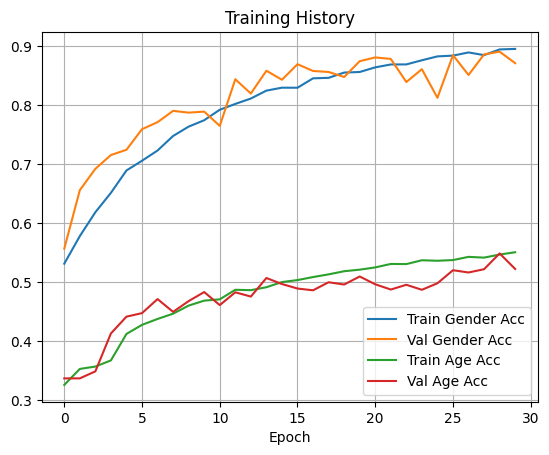

In [8]:
# =============================
# 5. Vẽ biểu đồ kết quả
# =============================
import matplotlib.pyplot as plt

plt.plot(history.history['gender_output_accuracy'], label='Train Gender Acc')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Acc')
plt.plot(history.history['age_output_accuracy'], label='Train Age Acc')
plt.plot(history.history['val_age_output_accuracy'], label='Val Age Acc')
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.grid(True)
plt.show()